In [1]:
import torch
import context
from ccn import Constraint, ConstraintsGroup, Clause, ClausesGroup, Literal, ConstraintsLayer
import matplotlib.pyplot as plt
import networkx as nx

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
constraints = ConstraintsGroup('../constraints/full')
print(len(constraints))

clauses = ClausesGroup.from_constraints_group(constraints)
print(len(clauses))

n0 = Literal(0, False)
clauses = [Clause([Literal(lit.atom + 1, lit.positive) for lit in clause] + [n0]) for clause in clauses]
clauses = ClausesGroup(clauses)

centrality = 'rev-katz'
constraints = clauses.stratify(centrality)
strata = len(constraints)
print(strata)

print(constraints[0].heads())
#print(constraints[1].heads())

lens = [len(group) for group in constraints]
print(lens)
print(sum(lens))


# for group in constraints:
#   print(str(group))
#   print('-----------')

243
243
11
{0}
[21, 9, 9, 15, 25, 20, 14, 50, 40, 23, 17]
243


In [4]:
def test():
  num_classes = 42
  total_classes = num_classes + 100
  elems = 1000
  layer = ConstraintsLayer(constraints, num_classes=num_classes).to(device)
  preds = torch.rand(elems, total_classes, device=device)
  extra = torch.rand_like(preds, requires_grad=True, device=device)
  total = preds + extra
  updated = layer(total)
  print(torch.cuda.memory_summary(abbreviated=True))

torch.cuda.empty_cache()
test()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   19630 KB |   19630 KB |   38016 KB |   18386 KB |
|---------------------------------------------------------------------------|
| Active memory         |   19630 KB |   19630 KB |   38016 KB |   18386 KB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |   20480 KB |   20480 KB |   20480 KB |       0 B  |
|---------------------------------------------------------------

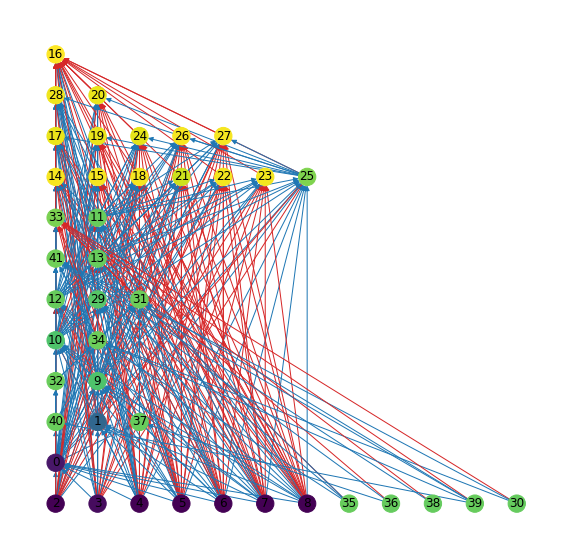

In [13]:
aux = ConstraintsGroup([])
for group in constraints:
  aux = aux + group 

G = aux.graph()

plt.figure(figsize=(10, 10))
ax = plt.subplot()

pos = dict()
for aid, atom in enumerate(aux.atoms().difference(aux.heads())):
  pos[atom] = (aid, -1)
for gid, group in enumerate(constraints):
  for aid, atom in enumerate(group.heads()):
    pos[atom] = (aid, gid)

centrality = clauses.centrality(centrality)
edge_color = ['tab:blue' if G[edge[0]][edge[1]]['body'] else 'tab:red' for edge in G.edges()]
node_color = [centrality[node] for node in G.nodes()]

nx.draw(G, with_labels=True, pos=pos, edge_color=edge_color, node_color=node_color)
plt.show()

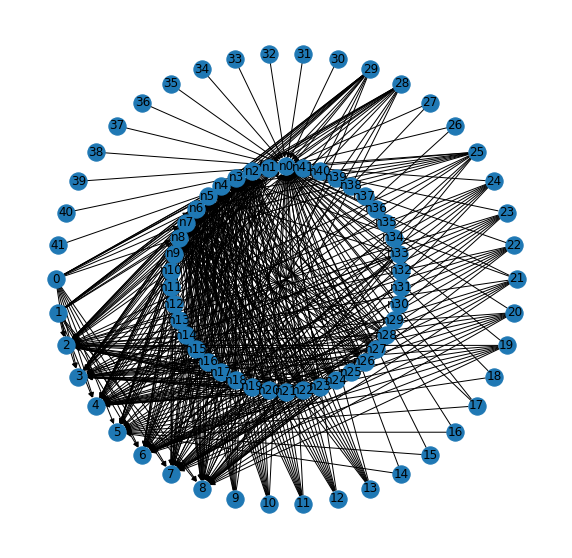

In [11]:
G = aux.duograph()

outer = [str(Literal(atom, True)) for atom in range(42)]
inner = [str(Literal(atom, False)) for atom in range(42)]

plt.figure(figsize=(10, 10))
ax = plt.subplot()
pos = nx.shell_layout(G, [inner, outer])
nx.draw(G, pos=pos, with_labels=True)
plt.show()

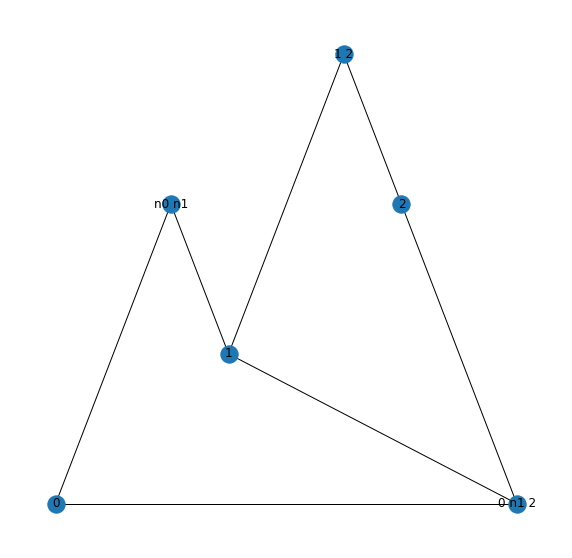

In [15]:
constraints = ConstraintsGroup('../constraints/example')
clauses = ClausesGroup.from_constraints_group(constraints)

plt.figure(figsize=(10, 10))
ax = plt.subplot()
nx.draw_planar(clauses.graph(), with_labels=True)
plt.show()

